# Triplet Network Tutorial

This tutorial will walk you through the creation of a Triplet Neural Network, which is often used for tasks like image similarity, signature verification, and one-shot learning. In this case, we will use the MNIST dataset to build the network, which will compare pairs of images and determine whether they belong to the same class or not.

## Step 1: Import Required Libraries
We will start by importing necessary libraries for data manipulation, neural networks, and visualization.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision.datasets import MNIST
from torch import optim

from tqdm import tqdm

## Variaveis de ambiente

In [2]:
EPOCHS = 15
EMBEDDING_SPACE = 3

## Step 2: Set Up Device
Here, we define whether we will be using a GPU (CUDA) or CPU for our computations. If a GPU is available, it will be used.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Step 3: Create a Custom Dataset for Triplet Networks
We will now create a custom dataset class `TripletDataset`. This dataset will provide pairs of images from the MNIST dataset, where each pair will either belong to the same class or to different classes. The label will indicate whether the images are similar (0 for same class, 1 for different classes).

In [4]:
class TripletDataset(Dataset):
    def __init__(self, data, transform=None):
        """
        Initializes the TripletDataset class.
        
        Args:
            data: List of tuples where each tuple contains (image, label).
            transform: Optional transform to be applied on a sample.
        """
        self.data = data  # Store the dataset.
        self.transform = transform  # Store the image transformation function.

    def _get_image_from_same_class(self, labelA):
        labelB = -1
        while labelB != labelA:
            imgB, labelB = random.choice(self.data)
        return imgB, labelB
    
    def _get_image_from_different_class(self, labelA):
        labelB = labelA
        while labelB == labelA:
            imgB, labelB = random.choice(self.data)
        return imgB, labelB
    
    def __getitem__(self, index):
        """
        Returns a sample from the dataset, consisting of two images and a label indicating
        if they belong to the same class.
        
        Args:
            index: Index of the first image in the dataset.
        
        Returns:
            imgA, imgB: A pair of images.
            label: A binary tensor indicating whether the images are from the same class (0) 
                   or different classes (1).
        """
        imgA, labelA = self.data[index]
        imgB, _ = self._get_image_from_same_class(labelA)
        imgC, _ = self._get_image_from_different_class(labelA)

        if self.transform:
            imgA = self.transform(imgA)
            imgB = self.transform(imgB)
            imgC = self.transform(imgC)

        return imgA, imgB, imgC

    def __len__(self):
        return len(self.data)
    

mnist_train = MNIST(root='../../data', train=True, download=True)
mnist_test = MNIST(root='../../data', train=False, download=True)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=10)
])

triplet_train = TripletDataset(mnist_train, transform)
triplet_test = TripletDataset(mnist_test, transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15768623.82it/s]


Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 471039.03it/s]


Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4406252.82it/s]


Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3846260.60it/s]

Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw



## Step 4: Visualize the Dataset
Let's visualize a few samples of image pairs from our custom `TripletDataset`. This will help us understand how the pairs are generated (same class or different class).

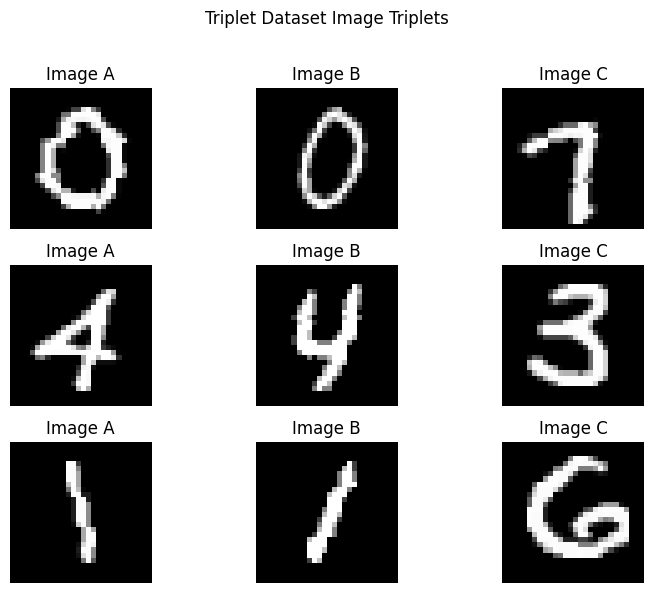

In [5]:
def plot_triplet_samples(dataset, num_samples=5):
    """
    Plots pairs of images from the TripletDataset along with their label indicating
    if they belong to the same class or different classes.
    
    Args:
        dataset: An instance of the TripletDataset.
        num_samples: Number of image pairs to plot.
    """
    fig, axes = plt.subplots(num_samples, 3, figsize=(8, num_samples * 2))
    fig.suptitle('Triplet Dataset Image Triplets')

    for i in range(num_samples):
        imgA, imgB, imgC = dataset[random.randint(0, len(dataset)-1)]
        imgA = imgA.cpu().squeeze().numpy()
        imgB = imgB.cpu().squeeze().numpy()
        imgC = imgC.cpu().squeeze().numpy()

        axes[i, 0].imshow(imgA, cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f'Image A')

        axes[i, 1].imshow(imgB, cmap='gray')
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Image B')

        axes[i, 2].imshow(imgC, cmap='gray')
        axes[i, 2].axis('off')
        axes[i, 2].set_title('Image C')

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.savefig('plot_triplet_samples.png')

# Example usage:
plot_triplet_samples(triplet_train, num_samples=3)

## Step 5: Build the Triplet Network Architecture
The `TripletNetwork` consists of two branches that share weights. These branches process the two input images, and the results are compared to determine the similarity. The architecture consists of convolutional layers followed by fully connected layers.
import torch.nn as nn

In [6]:
class Tower(nn.Module):
    def __init__(self):
        super(Tower, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2)
        )

        self.fc = nn.Sequential(
            nn.Linear(256 * 3 * 3, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256, EMBEDDING_SPACE)
        )

    def forward(self, x):
        output = self.cnn(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

In [7]:
class TripletNetwork(nn.Module):
    def __init__(self):
        super(TripletNetwork, self).__init__()
        self.tower = Tower()  # Shared tower network

    def forward(self, inputA, inputB, inputC):
        outputA = self.tower(inputA)
        outputB = self.tower(inputB)
        outputC = self.tower(inputC)
        return outputA, outputB, outputC

## Step 6: Define the Contrastive Loss Function
We use the contrastive loss function to optimize the Triplet Network. This loss function computes the distance between two outputs and penalizes the network based on whether they are from the same class or not.

In [8]:
class TripletLoss(torch.nn.Module):
    def __init__(self, margin=3.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        # Calculate distances between anchor-positive and anchor-negative
        pos_dist = F.pairwise_distance(anchor, positive, keepdim=True)
        neg_dist = F.pairwise_distance(anchor, negative, keepdim=True)

        # Calculate the triplet loss
        loss = torch.clamp(pos_dist - neg_dist + self.margin, min=0.0)

        return torch.mean(loss)

## Step 7: Training the Network
Now we will train the network using the `TripletDataset` and the `TripletLoss`. The training loop involves computing the loss for each image pair and updating the model parameters.

In [9]:
train_dataloader = DataLoader(triplet_train, shuffle=True, batch_size=128,)

triplet_model = TripletNetwork().to(device)
criterion = TripletLoss()
optimizer = optim.Adam(triplet_model.parameters(), lr=0.001)

for epoch in range(EPOCHS):
    total_loss = 0
    
    for imgA, imgB, imgC in tqdm(train_dataloader, desc=f"Train epoch: {epoch+1}"):
        imgA, imgB, imgC = imgA.to(device), imgB.to(device), imgC.to(device)
        optimizer.zero_grad()
        outputA, outputB, outputC = triplet_model(imgA, imgB, imgC)
        loss_contrastive = criterion(outputA, outputB, outputC)
        loss_contrastive.backward()

        total_loss += loss_contrastive.item()
        optimizer.step()

    print(f"Epoch {epoch}; Loss {total_loss}")

Train epoch: 1: 100%|██████████| 469/469 [02:15<00:00,  3.47it/s]


Epoch 0; Loss 174.3574760016054


Train epoch: 2: 100%|██████████| 469/469 [02:09<00:00,  3.62it/s]


Epoch 1; Loss 54.3263251890894


Train epoch: 3: 100%|██████████| 469/469 [02:08<00:00,  3.65it/s]


Epoch 2; Loss 34.784809693694115


Train epoch: 4: 100%|██████████| 469/469 [02:07<00:00,  3.68it/s]


Epoch 3; Loss 27.68282411247492


Train epoch: 5: 100%|██████████| 469/469 [02:08<00:00,  3.66it/s]


Epoch 4; Loss 22.058578670024872


Train epoch: 6: 100%|██████████| 469/469 [02:08<00:00,  3.66it/s]


Epoch 5; Loss 19.41233917325735


Train epoch: 7: 100%|██████████| 469/469 [02:08<00:00,  3.66it/s]


Epoch 6; Loss 18.21278641745448


Train epoch: 8: 100%|██████████| 469/469 [02:09<00:00,  3.63it/s]


Epoch 7; Loss 16.20331671088934


Train epoch: 9: 100%|██████████| 469/469 [02:09<00:00,  3.61it/s]


Epoch 8; Loss 14.757387546822429


Train epoch: 10: 100%|██████████| 469/469 [02:14<00:00,  3.48it/s]


Epoch 9; Loss 13.714796084910631


Train epoch: 11: 100%|██████████| 469/469 [02:15<00:00,  3.45it/s]


Epoch 10; Loss 13.490683317184448


Train epoch: 12: 100%|██████████| 469/469 [02:12<00:00,  3.54it/s]


Epoch 11; Loss 11.644848065450788


Train epoch: 13: 100%|██████████| 469/469 [02:11<00:00,  3.58it/s]


Epoch 12; Loss 10.569814082235098


Train epoch: 14: 100%|██████████| 469/469 [02:11<00:00,  3.57it/s]


Epoch 13; Loss 11.807511049322784


Train epoch: 15: 100%|██████████| 469/469 [02:12<00:00,  3.55it/s]

Epoch 14; Loss 9.582598846405745


## Step 8: Evaluate the Network
Now we will evaluate the network.

In [10]:
test_dataloader = DataLoader(triplet_test, shuffle=False, batch_size=64)

In [11]:

def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for imgA, imgB, imgC in dataloader:
            imgA, imgB, imgC = imgA.to(device), imgB.to(device), imgC.to(device)
            outputA, outputB, outputC = model(imgA, imgB, imgC)

            # Calculate the distances
            euclidean_distance_pos = F.pairwise_distance(outputA, outputB)
            euclidean_distance_neg = F.pairwise_distance(outputA, outputC)

            # Assume a threshold for classification
            predictions_pos = euclidean_distance_pos < 1.0  # Same class if distance is small
            predictions_neg = euclidean_distance_neg > 1.0  # Different class if distance is large

            # Count correct predictions
            correct_pos = predictions_pos.sum().item()
            correct_neg = predictions_neg.sum().item()

            total_correct += correct_pos + correct_neg
            total_samples += imgA.size(0) * 2  # Two comparisons per triplet

    accuracy = total_correct / total_samples
    return accuracy


accuracy = evaluate_model(triplet_model, test_dataloader)
print(f'Test Dataset Accuracy: {accuracy}%')

Test Dataset Accuracy: 0.53235%


## Step 8.1 - Plot some examples

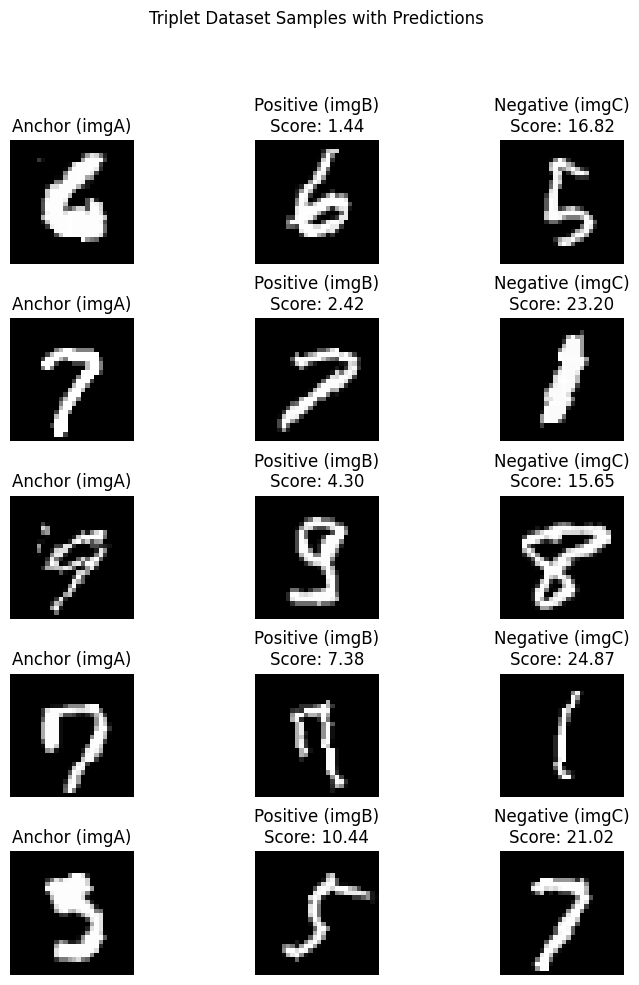

In [12]:
def plot_triplet_predict_samples(dataset, num_samples=5):
    """
    Plots triplets of images from the TripletDataset along with their predicted label 
    indicating if imgA and imgB belong to the same class and imgA and imgC to different classes.
    
    Args:
        dataset: An instance of the TripletDataset.
        num_samples: Number of image triplets to plot.
    """
    # Set up the plot with 3 columns for triplet images
    fig, axes = plt.subplots(num_samples, 3, figsize=(8, num_samples * 2))
    fig.suptitle('Triplet Dataset Samples with Predictions')

    for i in range(num_samples):
        # Randomly pick an index from the dataset
        imgA, imgB, imgC = dataset[random.randint(0, len(dataset) - 1)]
        imgA, imgB, imgC = imgA.to(device), imgB.to(device), imgC.to(device)

        # Get the model's outputs for each image in the triplet
        outputA, outputB, outputC = triplet_model(imgA.unsqueeze(0), imgB.unsqueeze(0), imgC.unsqueeze(0))

        # Compute pairwise distances (similarity scores)
        similarity_score_AB = F.pairwise_distance(outputA, outputB).cpu().item()
        similarity_score_AC = F.pairwise_distance(outputA, outputC).cpu().item()

        # Convert tensors to numpy arrays for plotting
        imgA = imgA.cpu().squeeze().numpy()
        imgB = imgB.cpu().squeeze().numpy()
        imgC = imgC.cpu().squeeze().numpy()

        # Plot imgA (Anchor)
        axes[i, 0].imshow(imgA, cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Anchor (imgA)')

        # Plot imgB (Positive)
        axes[i, 1].imshow(imgB, cmap='gray')
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f'Positive (imgB)\nScore: {similarity_score_AB:.2f}')

        # Plot imgC (Negative)
        axes[i, 2].imshow(imgC, cmap='gray')
        axes[i, 2].axis('off')
        axes[i, 2].set_title(f'Negative (imgC)\nScore: {similarity_score_AC:.2f}')

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.savefig('plot_triplet_predicted_samples.png')


# Example call to the function
plot_triplet_predict_samples(triplet_test, num_samples=5)

## Step 9 - Save Embedding Model

In [13]:
# Salvar o modelo da Tower
torch.save(triplet_model.tower.state_dict(), 'tower_model_triplet.pth')

## Step 10: Evaluate the Embedding Network
Let's test the network on a few image pairs from the test dataset and visualize the similarity scores.


In [14]:
# Carrega o modelo da Tower
tower_model = Tower().to(device)  # Ensure model is on the same device
tower_model.load_state_dict(torch.load('tower_model_triplet.pth', map_location=device))  # Load weights directly onto the device
tower_model.eval()  # Colocar o modelo em modo de avaliação

/tmp/ipykernel_23/542338239.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tower_model.load_state_dict(torch.load('tower_model_triplet.pth', map_location=device))  # Lo

Tower(
  (cnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=2304, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=3, bias=True)
  )
)

## Step 8: Test the Network
Let's test the network on a few image pairs from the test dataset and visualize the similarity scores.

In [15]:
mnist_test = MNIST(root='../../data', train=False, download=True)
test_tensor = TensorDataset(torch.tensor(mnist_test.data), torch.tensor(mnist_test.targets))
# Create a data loader from the tensor dataset
test_loader = DataLoader(test_tensor, batch_size=1, shuffle=False)


# EVAL USANDO TOWER:
for imgA, label in test_tensor:
    imgA = imgA.type(torch.float32).unsqueeze(0).unsqueeze(0).to(device)  
    outputA = tower_model(imgA)
    print(outputA)
    break

for imgA, label in test_loader:
    imgA = imgA.type(torch.float32).unsqueeze(0).to(device)  
    outputA = tower_model(imgA)
    print(outputA)
    break



tensor([[  417.4585, -1834.8566,  2651.2124]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[  417.4585, -1834.8566,  2651.2124]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


/tmp/ipykernel_23/1360879856.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_tensor = TensorDataset(torch.tensor(mnist_test.data), torch.tensor(mnist_test.targets))


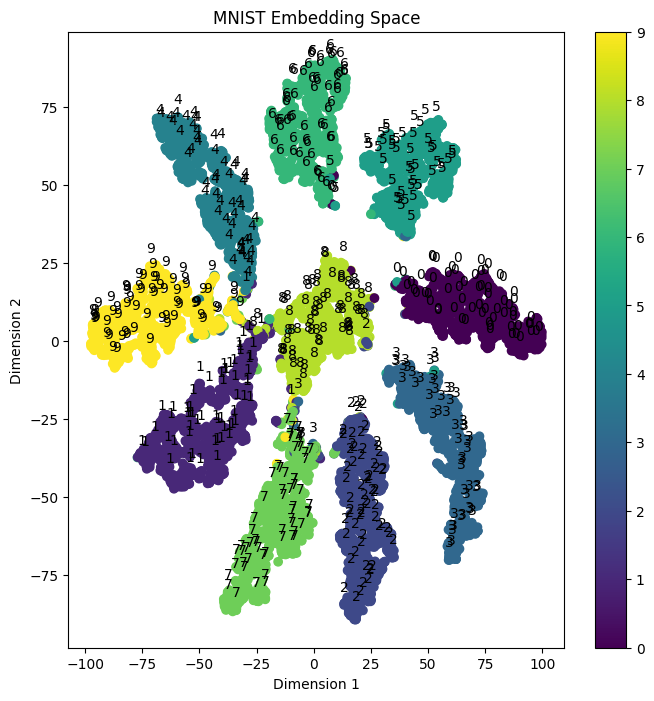

In [16]:
## Visualize the embeddings.
from sklearn.manifold import TSNE

# Define a function to extract embeddings from the tower model
# Create a data loader from the tensor dataset
# Define a function to extract embeddings from the tower model
def extract_embeddings(loader, model, device):
    embeddings = []
    labels = []
    with torch.no_grad():
        for x, y in loader:
            x = x.type(torch.float32)
            x = x.to(device)
            output = model(x.unsqueeze(0))
            embeddings.append(output.cpu().numpy())
            labels.append(y.cpu().numpy())
    return np.concatenate(embeddings), np.concatenate(labels)

# Use t-SNE to reduce the dimensionality of the embeddings
def visualizate_embeddings(embeddings, labels, annotation_sample=.06):
    # Use t-SNE to reduce the dimensionality of the embeddings
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Plot the embedding space
    plt.figure(figsize=(8, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels)

    # Sample x% of the labels for annotation
    sample_idx = np.random.choice(range(len(labels)), size=int(annotation_sample * len(labels)), replace=False)
    for i in sample_idx:
        x, y = embeddings_2d[i, 0], embeddings_2d[i, 1]
        plt.annotate(str(labels[i]), (x, y), textcoords="offset points", xytext=(0,10), ha='center')

    plt.title('MNIST Embedding Space')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.colorbar()
    plt.savefig('MNIST Embedding Space_tiplet_loss.png')

    
# Extract embeddings from the tower model
tower_model.eval()
embeddings, labels = extract_embeddings(test_loader, tower_model, device)
visualizate_embeddings(embeddings, labels)